In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import dolfin as dl
import numpy as np

from hippylib import *


import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

In [2]:
# create mesh and define function spaces
nx = 32
ny = 32
mesh = dl.UnitSquareMesh(nx, ny)
Vm = dl.FunctionSpace(mesh, 'Lagrange', 1)
Vu = dl.FunctionSpace(mesh, 'Lagrange', 2)

In [3]:
#Define model
mtrue = dl.interpolate(dl.Expression('std::log( 40. - 20.*(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < pow(0.2,2) ) )', degree=5), Vm)
omega = dl.Constant(1.0)
#ktrue = dl.interpolate(dl.Constant(5), Vk)

In [4]:
# define function for state, wavenumber and adjoint
u = dl.Function(Vu)
m = dl.Function(Vm)
p = dl.Function(Vu)

# define Trial and Test Functions
u_trial, m_trial, p_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vm), dl.TrialFunction(Vu)
u_test,  m_test,  p_test  = dl.TestFunction(Vu),  dl.TestFunction(Vm),  dl.TestFunction(Vu)

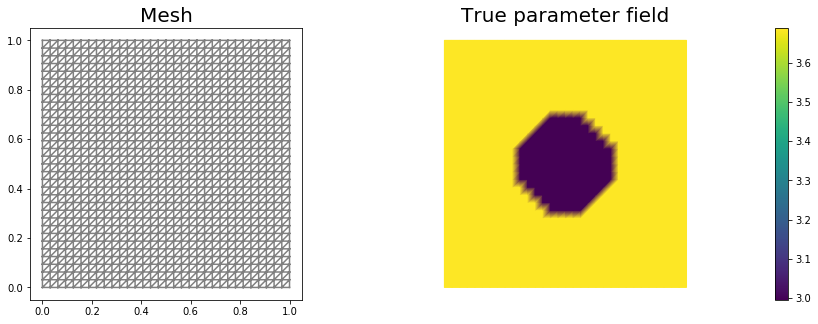

In [5]:
# plot
plt.figure(figsize=(15,5))
nb.plot(mesh,subplot_loc=121, mytitle="Mesh", show_axis='on')
nb.plot(mtrue,subplot_loc=122, mytitle="True parameter field")
plt.show()

In [6]:
sp1 = dl.Point(0.1,0.1)
ps1 = dl.PointSource(Vu, sp1, 1.0)

sp2 = dl.Point(0.5,0.1)
ps2 = dl.PointSource(Vu, sp2, 1.0)

In [7]:
def boundary(x, on_boundary):
    return on_boundary

bc_state = dl.DirichletBC(Vu, dl.Constant(0.0), boundary)

In [8]:
# define weak form of Helmholtz equation for synthetics 
a_true = (-dl.inner(dl.grad(u_trial), dl.grad(u_test)) + omega*omega*dl.inner(dl.exp(2*mtrue)*u_trial, u_test)) * dl.dx
L_true = dl.Constant(0.0) * u_test * dl.dx

In [9]:
A,b = dl.assemble_system(a_true, L_true, bc_state)
ps1.apply(b)
ps2.apply(b)
dl.solve(A, u.vector(),b)

1

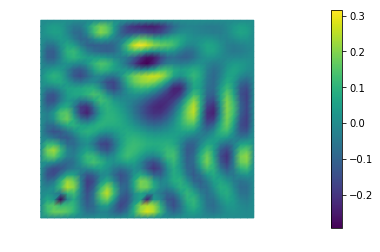

In [10]:
nb.plot(u)

# Something more interesting - synthetic data for our problem

In [11]:
import sys
sys.path.insert(0,'/home/fenics/Installations/MUQ_INSTALL/lib')

import pymuqModeling as mm
import pymuqApproximation as ma


In [12]:
numPts = nx
xDim = 2
yDim = 1

# Construct the grid points
x1 = np.linspace(0,1,numPts)
x2 = np.linspace(0,1,numPts)
X1, X2 = np.meshgrid(x1,x2)
x = np.zeros((2,numPts*numPts))

x[0,:] = X1.ravel()
x[1,:] = X2.ravel()

mean = ma.ZeroMean(xDim,yDim)
numSamps = 3

In [13]:
def PlotSamples2d(gp):
    gauss = gp.Discretize(x)
    fig, axs = plt.subplots(nrows=1, ncols=numSamps, figsize=(16,5))
    for i in range(numSamps):
        samp = gauss.Sample()
        axs[i].pcolor(X1, X2, np.reshape(samp, (numPts,numPts)))
        axs[i].set_title('Sample %d'%i)
        
    plt.show()

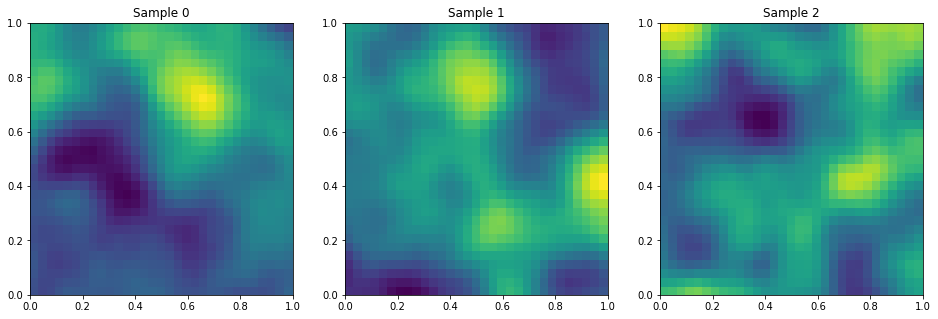

In [14]:
var = 0.1    # Marginal Variance
length = 0.2 # Lengthscale of the kernel
nu = 5.0/2.0 # Smoothness parameter

kern = ma.MaternKernel(xDim, var, length, nu)

gp = ma.GaussianProcess(mean, kern)

PlotSamples2d(gp)

In [15]:
gpd = gp.Discretize(x)

In [16]:
m_field = 1+gpd.Sample().reshape(nx,ny)

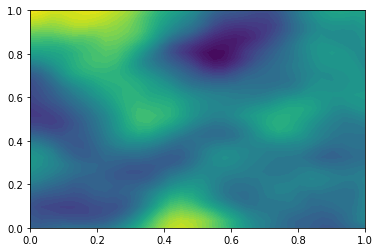

In [17]:
x = np.linspace(0,1,nx)
y = np.linspace(0,1,ny)
np.save('m_field', m_field)
plt.contourf(x,y,m_field.T, 50)

In [18]:
from scipy.interpolate import RegularGridInterpolator

class np2DArrayField(dl.Expression):
    def __init__(self, x, y, data, **kwargs):
        assert len(x), len(y) == data.shape
        self.data = data
        self.intrp = RegularGridInterpolator((x,y), data)
        
    def eval(self, values, x):
        values[0] = self.intrp([x[0], x[1]])

In [19]:
x = np.linspace(0,1,nx)
y = np.linspace(0,1,ny)
m_true_intrp = np2DArrayField(x,y,m_field,degree=1)
m_true = dl.interpolate(m_true_intrp, Vm)

In [20]:
xmlfile_m_true = dl.File("m_true.xml")
xmlfile_m_true << m_true

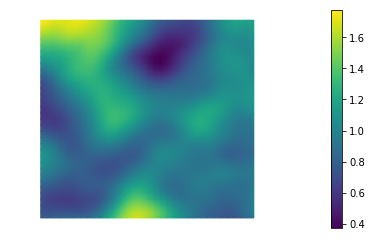

In [21]:
nb.plot(m_true)

In [22]:
def boundary(x, on_boundary):
    return on_boundary

bc_state = dl.DirichletBC(Vu, dl.Constant(0.0), boundary)

In [23]:
omega = dl.Constant(1.0)
#g = dl.Expression("DOLFIN_PI*exp(DOLFIN_PI*x[1])*sin(DOLFIN_PI*x[0])", degree=3)
g = dl.Constant(1.0)

In [24]:
# define weak form of Helmholtz equation for synthetics 
a_true = (-dl.inner(dl.grad(u_trial), dl.grad(u_test)) + omega*omega*dl.inner(dl.exp(2*m_true)*u_trial, u_test)) * dl.dx
L_true = -g * u_test * dl.ds

In [25]:
# sp1 = dl.Point(0.1,0.1)
# ps1 = dl.PointSource(Vu, sp1, 1.0)

In [26]:
A,b = dl.assemble_system(a_true, L_true, [])

In [27]:
b1 = b.copy()
# ps1.apply(b1)
dl.solve(A, u.vector(),b1)

1

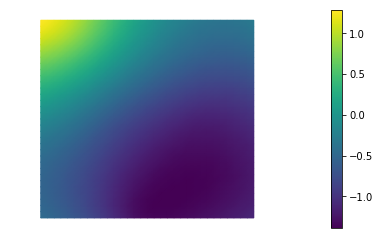

In [28]:
nb.plot(u)

In [29]:
test_locs = np.array([np.random.uniform(low=0,high=1,size=(2,)) for i in range(200)])

In [30]:
test_u = np.array([u(tl) for tl in test_locs])

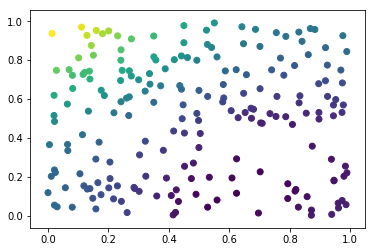

In [31]:
plt.scatter(test_locs[:,0],test_locs[:,1], c=test_u)

In [32]:
np.save('test_locs', test_locs)
np.save('test_u', test_u)

In [33]:
noise_level = 0.05
ud = dl.Function(Vu)
ud.assign(u)

# perturb state solution and create synthetic measurements ud
# ud = u + ||u||/SNR * random.normal
MAX = ud.vector().norm("linf")
noise = dl.Vector()
A.init_vector(noise,1)
noise.set_local( noise_level * MAX * np.random.normal(0, 1, len(ud.vector().get_local())) )

ud.vector().axpy(1., noise)

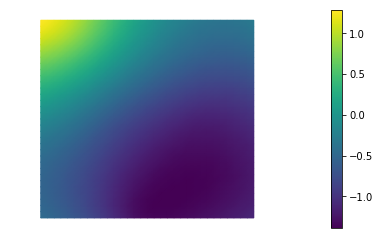

In [34]:
nb.plot(u)

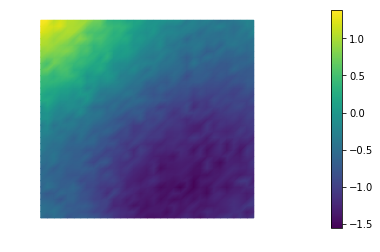

In [35]:
nb.plot(ud)

In [36]:
xmlfile_ud = dl.File("ud.xml")
xmlfile_ud << ud